In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.pool import NullPool
import matplotlib as plt
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import requests
from io import BytesIO



In [2]:
imp_df = pd.read_csv('imp_df_20201012.csv')

/Users/emilyPark/.pyenv/versions/bun-analytics/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
ad = imp_df[~imp_df['ad_type'].isna()]
non_ad = imp_df[imp_df['ad_type'].isna()]
ad['content_owner'] = ad['content_owner'].astype(str)
non_ad['content_owner'] = non_ad['content_owner'].astype(str)

/Users/emilyPark/.pyenv/versions/bun-analytics/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/emilyPark/.pyenv/versions/bun-analytics/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [4]:
ad_pid_cnt = ad.groupby('content_owner')['content_id'].nunique().reset_index()
ad_pid_cnt.columns = ['content_owner', 'content_cnt']
non_ad_pid_cnt = non_ad.groupby('content_owner')['content_id'].nunique().reset_index()
non_ad_pid_cnt.columns = ['content_owner', 'content_cnt']

In [7]:
ad_temp = ad[ad['content_owner'].isin(
    ad_pid_cnt[(ad_pid_cnt['content_cnt'] >= ad_pid_cnt['content_cnt'].quantile(0.25)) 
               & (ad_pid_cnt['content_cnt'] <= ad_pid_cnt['content_cnt'].quantile(0.75))]['content_owner'].unique())]

In [8]:
non_ad_temp = non_ad[non_ad['content_owner'].isin(
    non_ad_pid_cnt[(non_ad_pid_cnt['content_cnt'] >= non_ad_pid_cnt['content_cnt'].quantile(0.25)) 
               & (non_ad_pid_cnt['content_cnt'] <= non_ad_pid_cnt['content_cnt'].quantile(0.75))]['content_owner'].unique())]

In [99]:
ad_pid_imp_cnt = ad_temp.groupby('content_id')['imp_id'].size().reset_index()
non_ad_pid_imp_cnt = non_ad_temp.groupby('content_id')['imp_id'].size().reset_index()

In [100]:
ad_pid_imp_cnt.columns = ['content_id', 'imp_cnt']
non_ad_pid_imp_cnt.columns = ['content_id', 'imp_cnt']
ad_pid_imp_cnt['content_id'] = ad_pid_imp_cnt['content_id'].astype(str)
non_ad_pid_imp_cnt['content_id'] = non_ad_pid_imp_cnt['content_id'].astype(str)

In [101]:
ad_pid_imp_cnt['imp_cnt'] = ad_pid_imp_cnt['imp_cnt'] * 1.8
ad_pid_imp_cnt.describe()

,imp_cnt
count,2744.000000
mean,320.183528
std,571.518331
min,1.800000
25%,70.200000
50%,160.200000
75%,361.800000
max,10423.800000


In [102]:
non_ad_pid_imp_cnt['imp_cnt'] = non_ad_pid_imp_cnt['imp_cnt'] * 1.8
non_ad_pid_imp_cnt.describe()

,imp_cnt
count,139497.000000
mean,46.159625
std,82.812069
min,1.800000
25%,5.400000
50%,18.000000
75%,52.200000
max,3502.800000


In [23]:
q = '''
SELECT pid
FROM service1_quicket.product_up 
WHERE to_char(register_date, 'YYYY/MM/dd') = '2020/10/12'
'''
up_pids = pd.read_sql(q, con=bun_dw)

In [171]:
up_pids.to_csv('up_pids.csv', index=False)

In [24]:
non_ad_up_pids = up_pids[up_pids['pid'].isin(non_ad['content_id'].unique())]['pid'].unique()

In [26]:
up = non_ad_temp[non_ad_temp['content_id'].isin(non_ad_up_pids)]
non_up = non_ad_temp[~non_ad_temp['content_id'].isin(non_ad_up_pids)]

In [105]:
up.groupby('content_id', as_index=False)['imp_id'].agg(lambda x: len(x) * 1.8)['imp_id'].describe()

count    27365.000000
mean        82.912414
std        107.648214
min          1.800000
25%         21.600000
50%         50.400000
75%        104.400000
max       2422.800000
Name: imp_id, dtype: float64

In [106]:
non_up.groupby('content_id', as_index=False)['imp_id'].agg(lambda x: len(x) * 1.8)['imp_id'].describe()

count    112132.000000
mean         37.190374
std          72.756034
min           1.800000
25%           5.400000
50%          12.600000
75%          37.800000
max        3502.800000
Name: imp_id, dtype: float64

ad, non_ad : 전체  
ad_temp, non_ad_temp : 상품 갯수가 25%~75% 상점 샘플링

In [30]:
pids = ','.join('\'' + str(i) + '\'' for i in imp_df['content_id'].unique())

In [33]:
q = f'''
SELECT datediff(DAY, create_date, '2020-10-12') AS day_diff,
       id AS content_id
FROM service1_quicket.product_info
WHERE id IN ({pids})
'''

pid_created = pd.read_sql(q, con=bun_dw)

In [169]:
pid_created.to_csv('pid_created_day_diff.csv', index=False)

In [36]:
ad_temp = pd.merge(ad_temp, pid_created, on = 'content_id')
non_ad_temp = pd.merge(non_ad_temp, pid_created, on = 'content_id')

In [37]:
ad_temp.head()

,day,imp_id,ref_term,user_id,content_id,content_position,content_owner,category_id,ad_type,ad_id,day_diff
0,20201012,99735f83dccb19ec1394,플스4,2949586,133276922,5,3097368,600600002,ad_super_up,1.53588e+06,28
1,20201012,99985f83d86019c848d0,플스4,8455828,133276922,10,3097368,600600002,ad_super_up,1.53588e+06,28
2,20201012,99505f83dde919fff039,플스4,2949586,133276922,0,3097368,600600002,ad_super_up,1.53588e+06,28
3,20201012,99735f83d98719da19d8,ps4,12247782,133276922,20,3097368,600600002,ad_super_up,1.53588e+06,28
4,20201012,99505f838fcc189d6a1c,플스,11340630,133276922,5,3097368,600600002,ad_super_up,1.53588e+06,28


In [38]:
ad_temp.ad_type.unique()

array(['ad_super_up', 'ad_super_up_shop', 'power_up'], dtype=object)

In [91]:
ad_temp['category_id'] = ad_temp['category_id'].astype(str)
non_ad_temp['category_id'] = non_ad_temp['category_id'].astype(str)

category = [i[:3] for i in ad_temp['category_id']]
ad_temp['category'] = category

category = [i[:3] for i in non_ad_temp['category_id']]
non_ad_temp['category'] = category

In [116]:
super_up = ad_temp[ad_temp['ad_type'] == 'ad_super_up']
shop_up = ad_temp[ad_temp['ad_type'] == 'ad_super_up_shop']
power_up = ad_temp[ad_temp['ad_type'] == 'power_up']
non_ad = non_ad_temp[~non_ad_temp['content_id'].isin(non_ad_up_pids)]
non_ad_up = non_ad_temp[non_ad_temp['content_id'].isin(non_ad_up_pids)]

In [118]:
cache = {}

tempA = ad_temp.groupby('content_id', as_index=False)['day_diff'].mean()
tempB = non_ad_temp.groupby('content_id', as_index=False)['day_diff'].mean()

super_up_imp = super_up.groupby(['content_id', 'category'])['imp_id'].size().reset_index()
super_up_imp.columns = ['content_id', 'category', 'imp_cnt']
super_up_imp = pd.merge(super_up_imp, tempA, on='content_id')
cache['super_up'] = super_up
cache['super_up_imp'] = super_up_imp

shop_up_imp = shop_up.groupby(['content_id', 'category'])['imp_id'].size().reset_index()
shop_up_imp.columns = ['content_id', 'category', 'imp_cnt']
shop_up_imp = pd.merge(shop_up_imp, tempA, on='content_id')
cache['shop_up'] = shop_up
cache['shop_up_imp'] = shop_up_imp

power_up_imp = power_up.groupby(['content_id', 'category'])['imp_id'].size().reset_index()
power_up_imp.columns = ['content_id', 'category', 'imp_cnt']
power_up_imp = pd.merge(power_up_imp, tempA, on='content_id')
cache['power_up'] = power_up
cache['power_up_imp'] = power_up_imp

non_ad_imp = non_ad.groupby(['content_id', 'category'])['imp_id'].size().reset_index()
non_ad_imp.columns = ['content_id', 'category', 'imp_cnt']
non_ad_imp = pd.merge(non_ad_imp, tempB, on='content_id')
cache['non_ad'] = non_ad
cache['non_ad_imp'] = non_ad_imp

non_ad_up_imp = non_ad_up.groupby(['content_id', 'category'])['imp_id'].size().reset_index()
non_ad_up_imp.columns = ['content_id', 'category', 'imp_cnt']
non_ad_up_imp = pd.merge(non_ad_up_imp, tempB, on='content_id')
cache['non_ad_up'] = non_ad_up
cache['non_ad_up_imp'] = non_ad_up_imp

Text(0, 0.5, 'imp count')

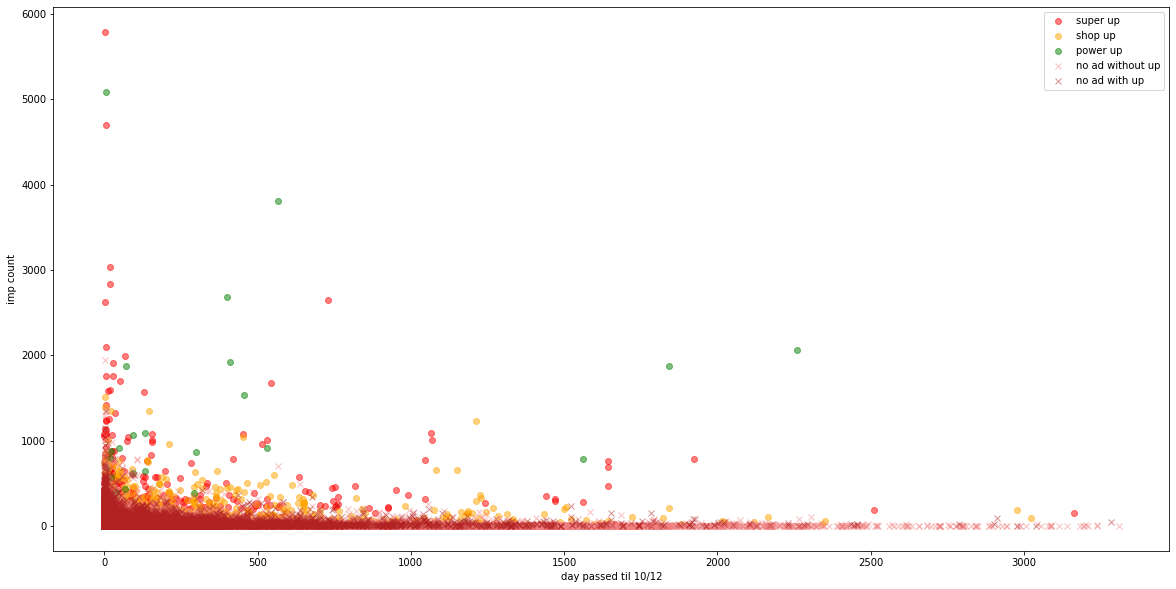

In [113]:
plt.figure(figsize=(20,10))

plt.plot(super_up_imp['day_diff'], super_up_imp['imp_cnt'], 'o', color = 'red', alpha = 0.5, label = 'super up')
plt.plot(shop_up_imp['day_diff'], shop_up_imp['imp_cnt'], 'o', color = 'orange', alpha = 0.5, label = 'shop up')
plt.plot(power_up_imp['day_diff'], power_up_imp['imp_cnt'], 'o', color = 'green', alpha = 0.5, label = 'power up')
plt.plot(non_ad_imp['day_diff'], non_ad_imp['imp_cnt'], 'x', markersize = 6, color = 'lightcoral', alpha = 0.5, label = 'no ad without up')
plt.plot(non_ad_up_imp['day_diff'], non_ad_up_imp['imp_cnt'], 'x', markersize = 6, color = 'firebrick', alpha = 0.5, label = 'no ad with up')
plt.legend()

plt.xlabel('day passed til 10/12')
plt.ylabel('imp count')

Text(0, 0.5, 'imp count')

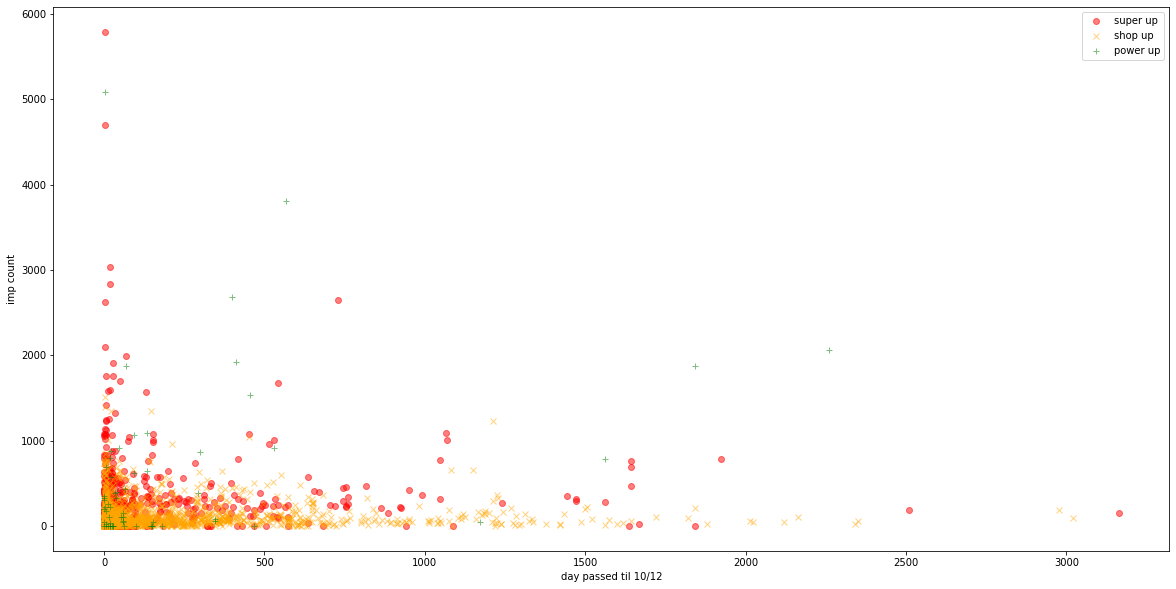

In [114]:
plt.figure(figsize=(20,10))

plt.plot(super_up_imp['day_diff'], super_up_imp['imp_cnt'], 'o', alpha = 0.5, color = 'red', label='super up')
plt.plot(shop_up_imp['day_diff'], shop_up_imp['imp_cnt'], 'x', alpha = 0.5, color = 'orange', label='shop up')
plt.plot(power_up_imp['day_diff'], power_up_imp['imp_cnt'], '+', alpha = 0.5, color = 'green', label='power up')

plt.legend()

plt.xlabel('day passed til 10/12')
plt.ylabel('imp count')

Text(0, 0.5, 'imp count')

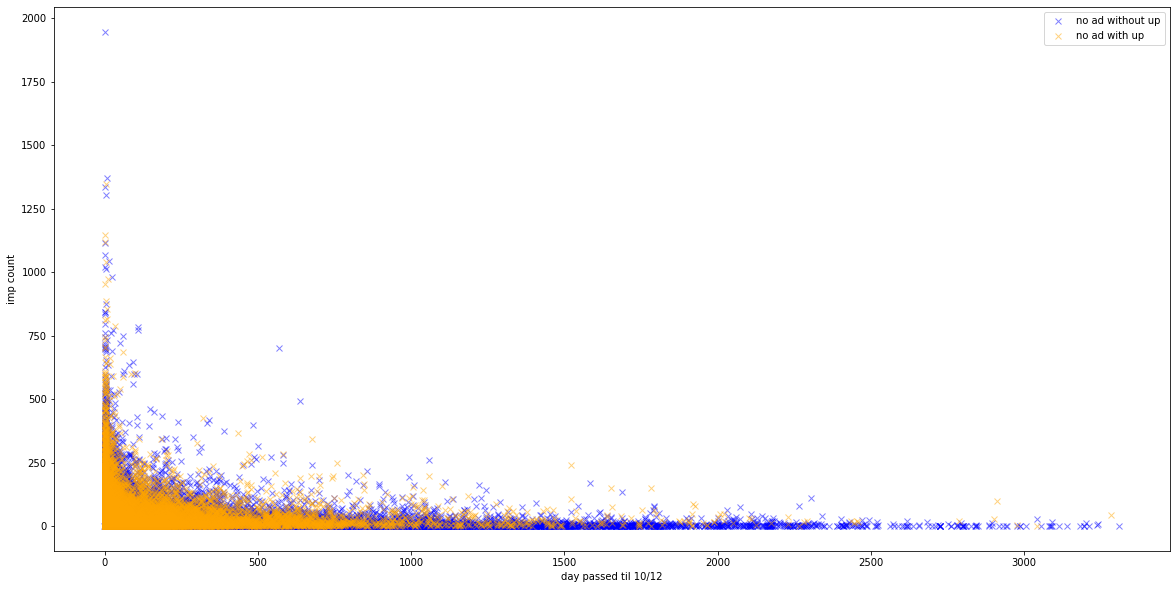

In [125]:
plt.figure(figsize=(20,10))

plt.plot(non_ad_imp['day_diff'], non_ad_imp['imp_cnt'], 'x', color = 'blue', alpha=0.5, label = 'no ad without up')
plt.plot(non_ad_up_imp['day_diff'], non_ad_up_imp['imp_cnt'], 'x', color = 'orange', alpha=0.5, label = 'no ad with up')
plt.legend()

plt.xlabel('day passed til 10/12', )
plt.ylabel('imp count')

Text(0, 0.5, 'imp count')

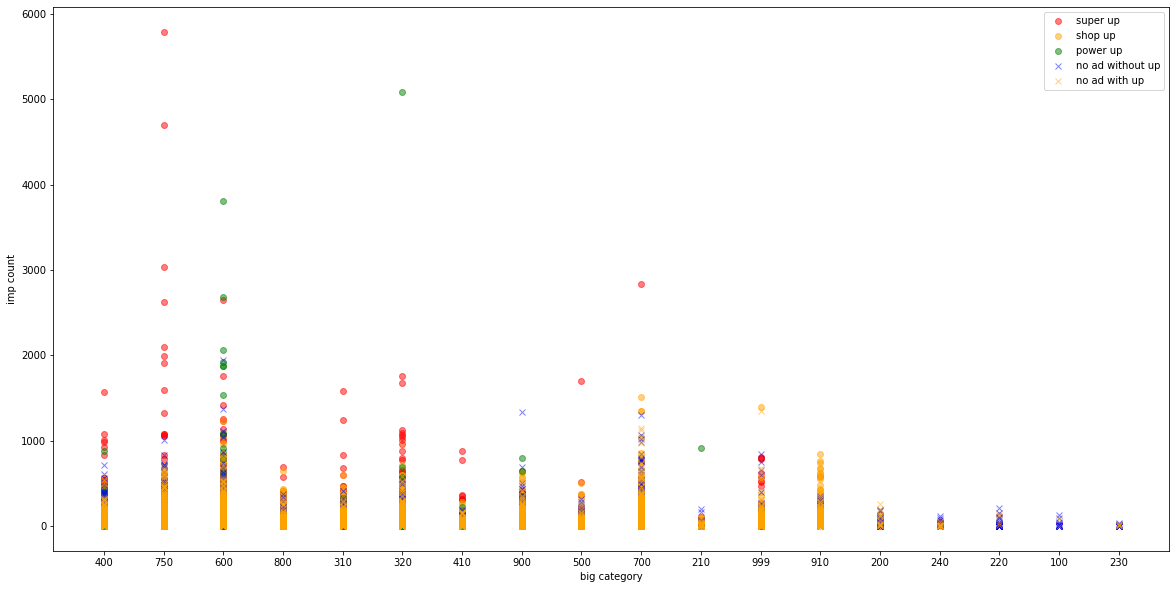

In [136]:
plt.figure(figsize=(20,10))

plt.plot(super_up_imp['category'], super_up_imp['imp_cnt'], 'o', color = 'red', alpha = 0.5, label = 'super up')
plt.plot(shop_up_imp['category'], shop_up_imp['imp_cnt'], 'o', color = 'orange', alpha = 0.5, label = 'shop up')
plt.plot(power_up_imp['category'], power_up_imp['imp_cnt'], 'o', color = 'green', alpha = 0.5, label = 'power up')
plt.plot(non_ad_imp['category'], non_ad_imp['imp_cnt'], 'x', markersize = 6, color = 'blue', alpha = 0.5, label = 'no ad without up')
plt.plot(non_ad_up_imp['category'], non_ad_up_imp['imp_cnt'], 'x', markersize = 6, color = 'orange', alpha = 0.5, label = 'no ad with up')
plt.legend()

plt.xlabel('big category')
plt.ylabel('imp count')

In [137]:
non_ad_imp[(non_ad_imp['imp_cnt']>1000) & (non_ad_imp['category'] == '900')]

,content_id,category,imp_cnt,day_diff
106936,135197612,900,1337,2


In [149]:
imp_df['ref_term'] = imp_df['ref_term'].fillna('')

In [150]:
import re

keyword = [' '.join(re.sub(r'(\\|\s|,)+', ' ', i).split()).strip() for i in imp_df['ref_term']]
imp_df['ref_term'] = keyword

Text(0, 0.5, 'imp count')

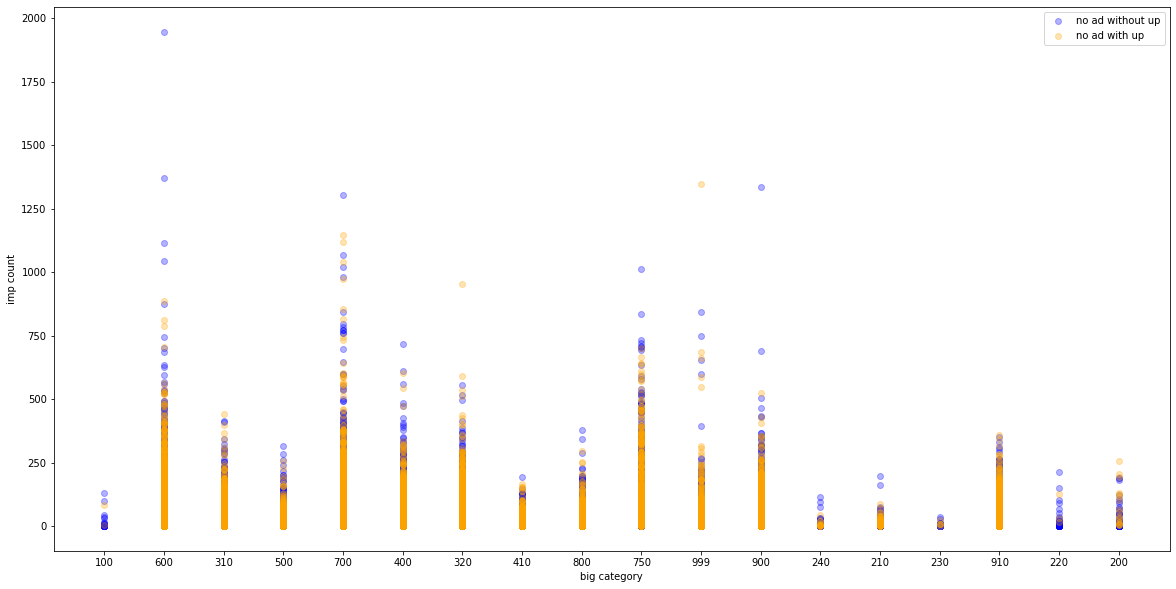

In [133]:
plt.figure(figsize=(20,10))

plt.plot(non_ad_imp['category'], non_ad_imp['imp_cnt'], 'o', markersize = 6, color = 'blue', alpha = 0.3, label = 'no ad without up')
plt.plot(non_ad_up_imp['category'], non_ad_up_imp['imp_cnt'], 'o', markersize = 6, color = 'orange', alpha = 0.3, label = 'no ad with up')
plt.legend()

plt.xlabel('big category')
plt.ylabel('imp count')

In [182]:
import numpy as np

keyword_cnt = imp_df.groupby('ref_term')['imp_id'].size().reset_index().sort_values('imp_id', ascending=False)
rank = np.array(range(1, len(keyword_cnt)+1))
rank_reverse = np.array(range(len(keyword_cnt), 0, -1))

keyword_cnt['rank'] = rank
keyword_cnt['rank_reverse'] = rank_reverse

In [177]:
imp_df = pd.merge(imp_df[['day', 'imp_id', 'ref_term', 'user_id', 'content_id',
       'content_position', 'content_owner', 'category_id', 'ad_type', 'ad_id']],
                  keyword_cnt[['ref_term', 'rank_reverse', 'rank']], on='ref_term')

In [168]:
imp_df.to_csv('imp_df_2.csv', index=False)